<a href="https://colab.research.google.com/github/liangchingyun/A-Convolution-Module-For-Variable-Input-Channels/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/liangchingyun/A-Convolution-Module-For-Variable-Input-Channels.git
%cd A-Convolution-Module-For-Variable-Input-Channels

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import argparse
from typing import Callable, Optional, Type, Union, List
import time
import matplotlib.pyplot as plt

In [2]:
class attention2d(nn.Module):
    def __init__(self, in_planes, ratios, K, temperature, init_weight=True):
        super(attention2d, self).__init__()
        assert temperature%3==1
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        if in_planes!=3:
            hidden_planes = int(in_planes*ratios)+1
        else:
            hidden_planes = K
        self.fc1 = nn.Conv2d(in_planes, hidden_planes, 1, bias=False)
        # self.bn = nn.BatchNorm2d(hidden_planes)
        self.fc2 = nn.Conv2d(hidden_planes, K, 1, bias=True)
        self.temperature = temperature
        if init_weight:
            self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m ,nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def updata_temperature(self):
        if self.temperature!=1:
            self.temperature -=3
            print('Change temperature to:', str(self.temperature))


    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x).view(x.size(0), -1)
        return F.softmax(x/self.temperature, 1)

class Dynamic_conv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, ratio=0.25, stride=1, padding=0, dilation=1, groups=1, bias=True, K=4,temperature=34, init_weight=True):
        super(Dynamic_conv2d, self).__init__()
        assert in_planes%groups==0
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.K = K
        self.attention = attention2d(in_planes, ratio, K, temperature)

        self.weight = nn.Parameter(torch.randn(K, out_planes, in_planes//groups, kernel_size, kernel_size), requires_grad=True)
        if bias:
            self.bias = nn.Parameter(torch.zeros(K, out_planes))
        else:
            self.bias = None
        if init_weight:
            self._initialize_weights()

        #TODO 初始化
    def _initialize_weights(self):
        for i in range(self.K):
            nn.init.kaiming_uniform_(self.weight[i])


    def update_temperature(self):
        self.attention.updata_temperature()

    def forward(self, x):#将batch视作维度变量，进行组卷积，因为组卷积的权重是不同的，动态卷积的权重也是不同的
        softmax_attention = self.attention(x)
        batch_size, in_planes, height, width = x.size()
        x = x.view(1, -1, height, width)# 变化成一个维度进行组卷积
        weight = self.weight.view(self.K, -1)

        # 动态卷积的权重的生成， 生成的是batch_size个卷积参数（每个参数不同）
        aggregate_weight = torch.mm(softmax_attention, weight).view(batch_size*self.out_planes, self.in_planes//self.groups, self.kernel_size, self.kernel_size)
        if self.bias is not None:
            aggregate_bias = torch.mm(softmax_attention, self.bias).view(-1)
            output = F.conv2d(x, weight=aggregate_weight, bias=aggregate_bias, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups*batch_size)
        else:
            output = F.conv2d(x, weight=aggregate_weight, bias=None, stride=self.stride, padding=self.padding,
                              dilation=self.dilation, groups=self.groups * batch_size)

        output = output.view(batch_size, self.out_planes, output.size(-2), output.size(-1))
        return output


ResNet

In [3]:
__all__ = ["ResNet", "resnet18"]

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_channels=3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def _resnet(arch, block, layers, pretrained, progress, num_channels, **kwargs):
    model = ResNet(block, layers, num_channels=num_channels, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained=False, progress=True, num_channels=3, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        num_channels (int): Number of input channels
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress, num_channels, **kwargs)

DY-ResNet

In [4]:

__all__ = ['DY_ResNet', 'dy_resnet18']

def dy_conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return Dynamic_conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation, groups=groups, bias=False, dilation=dilation)

def dy_conv1x1(in_planes, out_planes, stride=1):
    return Dynamic_conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False,)

class DY_BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(DY_BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = dy_conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = dy_conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class DY_ResNet(nn.Module):

    def __init__(self, block, layers, num_channels=3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(DY_ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, DY_BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)


    def update_temperature(self):
        for m in self.modules():
            if isinstance(m, Dynamic_conv2d):
                m.update_temperature()


    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                dy_conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def _dyresnet(arch, block, layers, pretrained, progress, num_channels, **kwargs):
    model = DY_ResNet(block, layers, num_channels=num_channels, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model

def dy_resnet18(pretrained=False, progress=True, num_channels=3, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        num_channels (int): Number of input channels
    """
    return _dyresnet('resnet18', DY_BasicBlock, [2, 2, 2, 2], pretrained, progress, num_channels, **kwargs)

Training

In [5]:

parser = argparse.ArgumentParser(description='dynamic convolution')
parser.add_argument('--batch-size', type=int, default=256)
parser.add_argument('--test-batch-size', type=int, default=20)
parser.add_argument('--epochs', type=int, default=40)
parser.add_argument('--lr', type=float, default=0.1, )
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--weight-decay', type=float, default=1e-4)
parser.add_argument('--net-name', default='dy_resnet18')
parser.add_argument('--channel', default='R')



parser.add_argument('-f')

args, unknown = parser.parse_known_args()
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

numclasses=50


def select_channels(image, channels):
    if channels == 'R':
        return image[0, :, :].unsqueeze(0)  # 只選R通道
    elif channels == 'G':
        return image[1, :, :].unsqueeze(0)  # 只選G通道
    elif channels == 'B':
        return image[2, :, :].unsqueeze(0)  # 只選B通道
    elif channels == 'RG':
        return image[:2, :, :]  # 選RG通道
    elif channels == 'GB':
        return image[1:, :, :]  # 選GB通道
    elif channels == 'RB':
        return image[[0, 2], :, :]  # 選RB通道
    else:  # 默認RGB
        return image

def get_transforms(channel):
    transform_list = [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: select_channels(x, channel)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406][:len(channel)], std=[0.229, 0.224, 0.225][:len(channel)])]
    return transforms.Compose(transform_list)

transform = get_transforms(args.channel)

# load dataset
'''train_dataset = torchvision.datasets.ImageFolder(root='train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='test', transform=transform)'''
train_dataset = torchvision.datasets.ImageFolder(root='A-Convolution-Module-For-Variable-Input-Channels/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='A-Convolution-Module-For-Variable-Input-Channels/val', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='A-Convolution-Module-For-Variable-Input-Channels/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

if args.net_name=='dy_resnet18':
    model = dy_resnet18(num_channels=len(args.channel), num_classes=numclasses)
else:
    model = resnet18(num_channels=len(args.channel), num_classes=numclasses)

model.to(args.device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
print(str(args))

def adjust_lr(optimizer, epoch):
    if epoch in [30, 60, 90]: #[args.epochs*0.5, args.epochs*0.75, args.epochs*0.85]
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
            lr = p['lr']
        print('Change lr:'+str(lr))

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train(epoch):
    model.train()
    avg_loss = 0.
    train_acc = 0.
    adjust_lr(optimizer, epoch)
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(args.device), target.to(args.device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        avg_loss += loss.item()
        pred = output.data.max(1, keepdim=True)[1]
        train_acc += pred.eq(target.data.view_as(pred)).cpu().sum()
        loss.backward()

        optimizer.step()
    
    
    avg_loss /= len(train_loader)
    train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    
    print('Train Epoch: {}, loss {:.6f}, acc {:.4f}'.format(epoch, avg_loss, train_acc), end='')
    if args.net_name.startswith('dy'):
        model.update_temperature()


def val(epoch):
    model.eval()
    val_loss = 0.
    correct=0.
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(args.device), label.to(args.device)
            output = model(data)
            val_loss += F.cross_entropy(output, label, size_average=False).item()
            pred =  output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).cpu().sum()
    val_loss/=len(val_loader.dataset)
    correct = int(correct)
    val_losses.append(val_loss)
    val_acc = correct / len(val_loader.dataset)
    val_accuracies.append(val_acc)
    print('Val set: average loss: {:.4f}, accuracy {:.4f}'.format(val_loss, 100. * val_acc))
    return val_acc


best_val_acc=0.
for i in range(args.epochs):
    train(i+1)
    temp_acc = val(i+1)
    if temp_acc>best_val_acc:
        best_val_acc = temp_acc
print('Best Val acc{}'.format(best_val_acc))

# Test

model.eval()
test_loss = 0.
correct=0.
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(args.device), label.to(args.device)
        output = model(data)
        test_loss += F.cross_entropy(output, label, size_average=False).item()
        pred =  output.data.max(1, keepdim=True)[1]
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()

test_loss/=len(test_loader.dataset)
correct = int(correct)
print(f'Test Accuracy: {correct/len(test_loader.dataset):.4f}')




Namespace(batch_size=256, test_batch_size=20, epochs=40, lr=0.1, momentum=0.9, weight_decay=0.0001, net_name='dy_resnet18', channel='RG', f=None, device='cuda:0')
Train Epoch: 1, loss 3.814621, acc 0.0495Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31
Change temperature to: 31


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: average loss: 3.7897, accuracy 7.3333
Train Epoch: 2, loss 3.260364, acc 0.1335Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Change temperature to: 28
Val set: average loss: 3.1848, accuracy 12.6667
Train Epoch: 3, loss 2.980565, acc 0.1890Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperature to: 25
Change temperatur

#PARAMS:  44984522


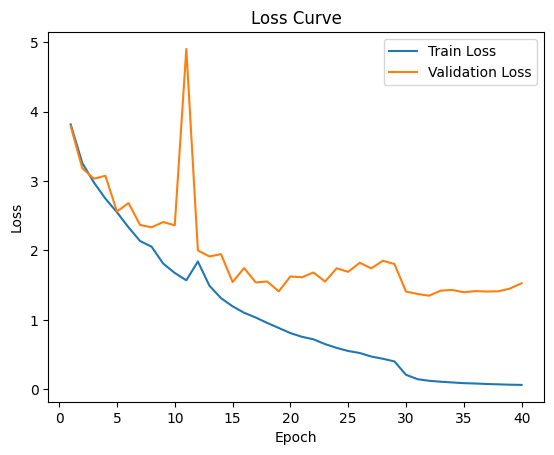

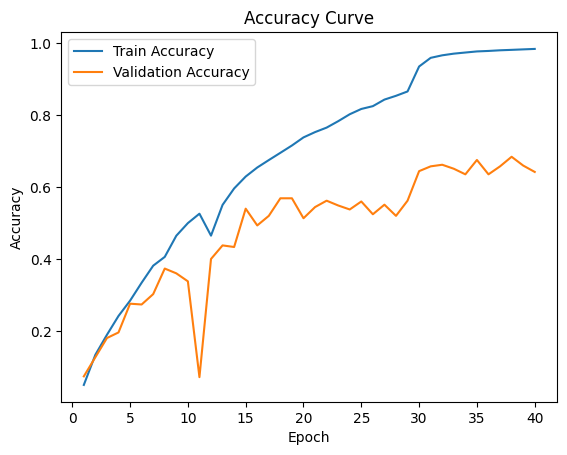

In [6]:
def params_count(model):
    return np.sum([p.numel() for p in model.parameters()]).item()

print('#PARAMS: ',params_count(model))

train_losses = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
val_losses = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in val_losses]
train_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_accuracies]
val_accuracies = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in val_accuracies]


plt.figure()
plt.plot(range(1, args.epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, args.epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# 绘制训练和验证的准确度曲线
plt.figure()
plt.plot(range(1, args.epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, args.epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()


In [11]:
import torch
torch.cuda.is_available()
torch.cuda.empty_cache()

In [1]:
! git config --global user.email "joanne10021@gmail.com"
! git config --global user.name "liangchingyun"